In [16]:
import pandas as pd

review_df = pd.read_csv('./data/labeledTrainData.tsv', header=0, sep="\t", quoting=3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [17]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />',' ')

# 파이썬의 정규 표현식 모듈인 re를 이용하여 영어 문자열이 아닌 문자는 모두 공백으로 변환 
review_df['review'] = review_df['review'].apply( lambda x : re.sub("[^a-zA-Z]", " ", x) )


In [18]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id','sentiment'], axis=1, inplace=False)

X_train, X_test, y_train, y_test= train_test_split(feature_df, class_df, test_size=0.3, random_state=156)

X_train.shape, X_test.shape

((17500, 1), (7500, 1))

### 비지도학습 기반 감성 분석 소개
### SentiWordNet을 이용한 Sentiment Analysis 
* WordNet Synset과 SentiWordNet SentiSynset 클래스의 이해

In [19]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_

True

In [20]:
# import nltk
# from nltk.corpus import sentiwordnet as swn

# senti_synsets = list(swn.senti_synsets('slow'))
# print('senti_synsets() 반환 type :', type(senti_synsets))
# print('senti_synsets() 반환 값 갯수:', len(senti_synsets))
# print('senti_synsets() 반환 값 :', senti_synsets)


In [21]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
# 명사는 대부분 긍정감성, 부정감성 점수가 없고 객관성 지수만 1인 특징을 가짐
print('father 긍정감성 지수: ', father.pos_score())
print('father 부정감성 지수: ', father.neg_score())
print('father 객관성 지수: ', father.obj_score())
print('\n')

# mother = swn.senti_synset('mother.n.01')
# print('mother 긍정감성 지수: ', mother.pos_score())
# print('mother 부정감성 지수: ', mother.neg_score())
# print('mother 객관성 지수: ', mother.obj_score())
# print('\n')
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수: ',fabulous .pos_score())
print('fabulous 부정감성 지수: ',fabulous .neg_score())

terrible = swn.senti_synset('terrible.a.01')
print('\nterrible 긍정감성 지수: ',terrible .pos_score())
print('terrible 부정감성 지수: ',terrible .neg_score())

father 긍정감성 지수:  0.0
father 부정감성 지수:  0.0
father 객관성 지수:  1.0


fabulous 긍정감성 지수:  0.875
fabulous 부정감성 지수:  0.125

terrible 긍정감성 지수:  0.0
terrible 부정감성 지수:  0.625


### SentiWordNet을 이용한 영화 감상평 감성 분석

In [22]:
from nltk.corpus import wordnet as wn

# 간단한 NTLK PennTreebank Tag를 기반으로 WordNet기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return 


In [23]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화 
    sentiment = 0.0
    tokens_count = 0
    
    lemmatizer = WordNetLemmatizer() # 영어 단어인경우에 표제어를 추출하는 과정
    # 표제어: 변형가능한 단어의 중심 단어
    # 예) am, is, are, was, were => be
    # 표제어 관련 전처리는 영어에 대해서 진행한다. 
    # (한국어는 한국어의 특성상) 어근 분리 정도만 한다.
    raw_sentences = sent_tokenize(text)
    # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산 
    for raw_sentence in raw_sentences:
        # NTLK 기반의 품사 태깅 문장 추출  
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word , tag in tagged_sentence:
            
            # WordNet 기반 품사 태깅과 어근 추출
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN , wn.ADJ, wn.ADV):
                continue                   
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성. 
            synsets = wn.synsets(lemma , pos=wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산. 
            synset = synsets[0] # 감성분석을 하기 위해 synsets의 첫번째 값을 선택
            swn_synset = swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())           
            tokens_count += 1
    
    if not tokens_count:
        return 0
    
    # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
    if sentiment >= 0 :
        return 1
    
    return 0


In [24]:
review_df['preds'] = review_df['review'].apply( lambda x : swn_polarity(x) )
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score 
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix( y_target, preds))
print("정확도:", np.round(accuracy_score(y_target , preds), 4))
print("정밀도:", np.round(precision_score(y_target , preds),4))
print("재현율:", np.round(recall_score(y_target, preds), 4))
print("F-1 Score:", np.round(f1_score(y_target, preds), 4))

[[7668 4832]
 [3636 8864]]
정확도: 0.6613
정밀도: 0.6472
재현율: 0.7091
F-1 Score: 0.6767


* 정밀도, 재현율, F-1 Score는 정확도에 대한 보조지표

### Confusion Matrix
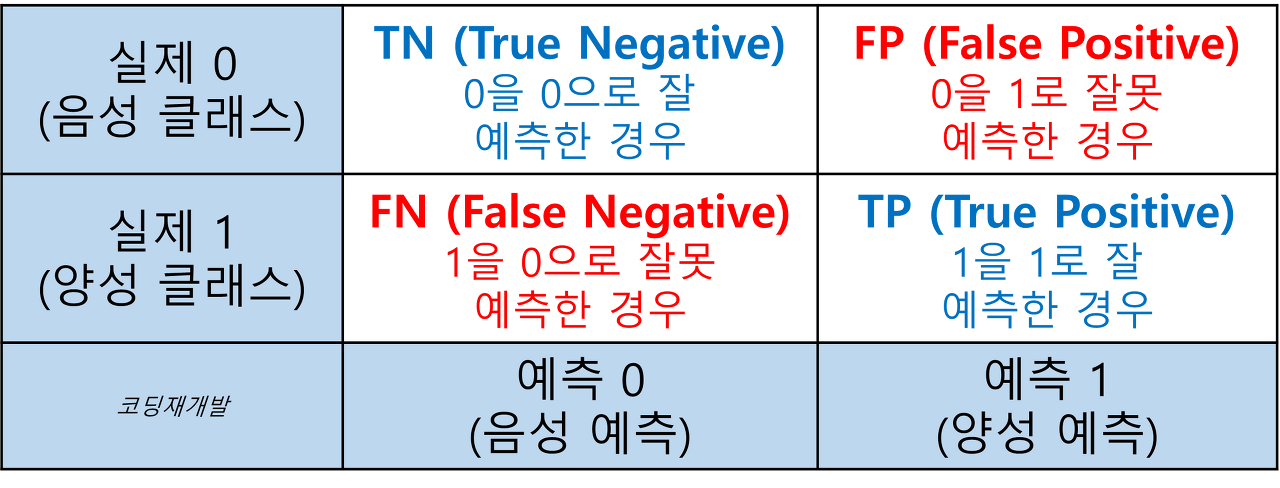
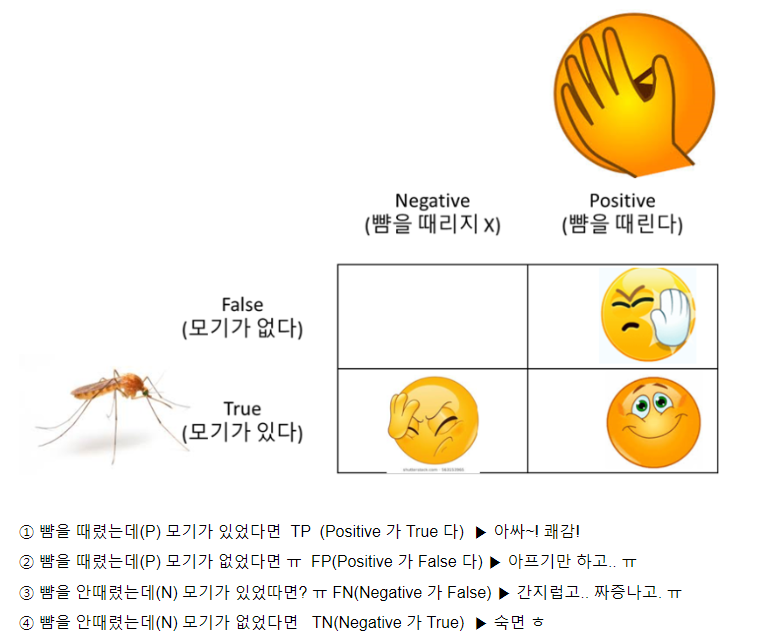

### 정밀도(Precision)
* TP / P  =  TP / (FP + TP)
* Positivie로 예측한 것 중에서 실제로 True인 비율 
 - 예: 암 진단 양성 예측한 건수에서 실제로 양성인 건수
* 정밀도가 중요한 경우
 - 스팸인 줄 알았는데(Positive) 실제론 아니었다(False). → 중요한 이메일이 누락됐다. 때문에 거액의 거래를 놓쳤다. → False Positive (2종 오류)
 - 스팸이 아닌 줄 알았는데(Negative) 실제론 스팸이었다(True). → 휴지통으로 이동한다. 약간 귀찮군. → True Negative (1종 오류)
 - 스팸이라고 판단하는 "Positive" 예측에 신중을 기해야 하고, 실제로 스팸메일 중에서 잘못된 False Positive 예측이 얼마나 포함되었는지 판단하는 정밀도[TP/(TP+FP)]가 더 중요한 척도

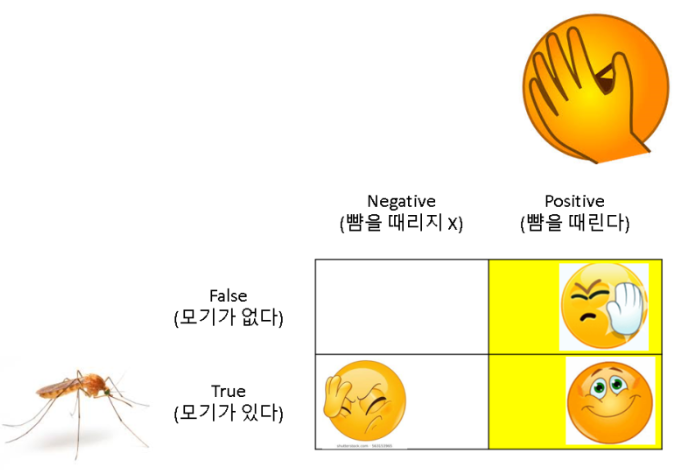

### 재현율
*  TP  / ( True)  = TP / (FN + TP)

* 재현율 해석
 - 암인 줄 알았는데(Positive) 실제론 아니었다(False). → 다행이다. 해프닝 → False Positive (2종 오류)
 - 암이 아닌 줄 알았는데(Negative) 실제로 암이었다(True). → 치료시기를 놓쳤다. 아주 위험하다. → True Negative (1종 오류)
 - 이 경우에는 2번이 훨씬 영향을 미치므로, 모델은 "Negative" 예측을 할 때 신중에 신중을 기해야 한다. 즉, 실제 결과에서 잘못된 False Negative 예측이 얼마나 포함되었는지 판단하는 재현율[TP/(TP+FN)]이 훨씬! 중요한 척도
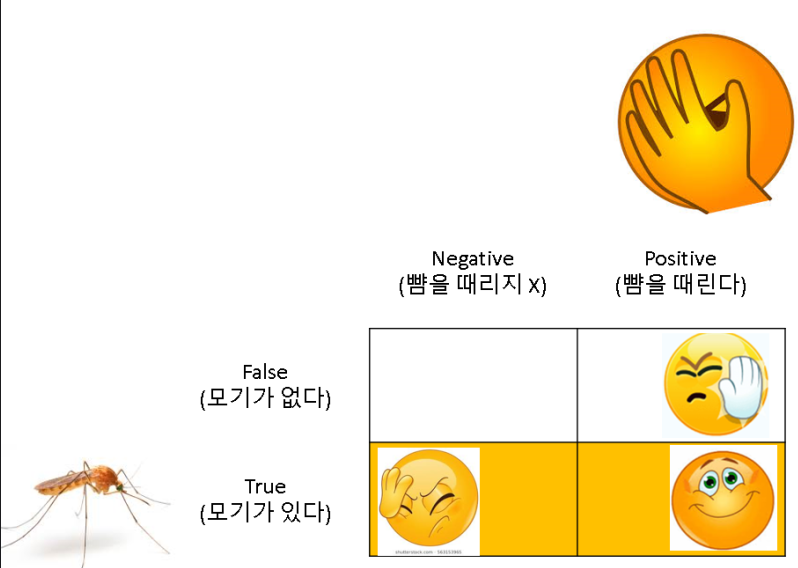

### F1-Score
* 정밀도와 재현율 모두를 고려한 성능
 - F1 = (2*정밀도*재현율) / (정밀도 + 재현율)

### 분류성능평가지표

https://sumniya.tistory.com/26

### VADER lexicon을 이용한 Sentiment Analysis

In [26]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


In [27]:
senti_analyzer.polarity_scores('happy')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}

In [28]:
def vader_polarity(review,threshold=0.1):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    # compound 값에 기반하여 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환 
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    return final_sentiment

# apply lambda 식을 이용하여 레코드별로 vader_polarity( )를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply( lambda x : vader_polarity(x, 0.1) )
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix( y_target, vader_preds))
print("정확도:", np.round(accuracy_score(y_target , vader_preds),4))
print("정밀도:", np.round(precision_score(y_target , vader_preds),4))
print("재현율:", np.round(recall_score(y_target, vader_preds),4))
print("F-1 Score:", np.round(f1_score(y_target, vader_preds),4))

[[ 6747  5753]
 [ 1858 10642]]
정확도: 0.6956
정밀도: 0.6491
재현율: 0.8514
F-1 Score: 0.7366
